# Title

## Introduction

!!! INTRO

### Required packages

### uncomment and run below if altair not installed

In [24]:
# import sys
# !{sys.executable} -m pip install altair

In [25]:
import pandas as pd
import numpy as np
import altair as alt
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import datetime as dt
# from datetime import datetime    
# sns.set_style("whitegrid")
# from pandas.plotting import autocorrelation_plot
# plt.style.use("ggplot")
from pandas.plotting import lag_plot
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error

### Loading required dataset

In [26]:
# Amazon
amzn = pd.read_csv('data/AMZN.csv').iloc[3684:]

In [27]:
# Apple
aapl = pd.read_csv('data/AAPL.csv').iloc[7836:]

In [28]:
# Microsft
msft = pd.read_csv('data/MSFT.csv').iloc[6510:]

## Exploratory Data Analysis

In [29]:
amzn.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
3684,04-01-2012,8.8035,8.9605,84104000,9.0250,8.8755,8.8755
3685,05-01-2012,8.7025,8.7970,76182000,8.9125,8.8805,8.8805
3686,06-01-2012,8.8750,8.9035,140168000,9.2325,9.1305,9.1305
3687,09-01-2012,8.8500,9.1380,101138000,9.2185,8.9280,8.9280
3688,10-01-2012,8.8550,9.0550,79716000,9.1200,8.9670,8.9670


In [30]:
aapl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
7836,04-01-2012,14.617143,14.642857,260022000,14.810000,14.765714,12.586558
7837,05-01-2012,14.738214,14.819643,271269600,14.948214,14.929643,12.726295
7838,06-01-2012,14.972143,14.991786,318292800,15.098214,15.085714,12.859331
7839,09-01-2012,15.048214,15.196429,394024400,15.276786,15.061786,12.838937
7840,10-01-2012,15.053571,15.211071,258196400,15.214286,15.115714,12.884903


In [31]:
print(amzn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2754 entries, 3684 to 6437
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2754 non-null   object 
 1   Low             2754 non-null   float64
 2   Open            2754 non-null   float64
 3   Volume          2754 non-null   int64  
 4   High            2754 non-null   float64
 5   Close           2754 non-null   float64
 6   Adjusted Close  2754 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 150.7+ KB
None


In [32]:
msft.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
6510,04-01-2012,26.780001,26.820000,80516100,27.469999,27.400000,22.260885
6511,05-01-2012,27.290001,27.379999,56081400,27.730000,27.680000,22.488358
6512,06-01-2012,27.530001,27.530001,99455500,28.190001,28.110001,22.837715
6513,09-01-2012,27.719999,28.049999,59706800,28.100000,27.740000,22.537107
6514,10-01-2012,27.750000,27.930000,60014400,28.150000,27.840000,22.618357


In [33]:
amzn.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,2754.000000,2754.000000,2.754000e+03,2754.000000,2754.000000,2754.000000
mean,67.219611,68.083358,8.059073e+07,68.857192,68.047067,68.047067
std,53.347081,54.083415,4.308913e+07,54.739446,54.028135,54.028135
min,8.600000,8.690500,1.762600e+07,8.912500,8.796500,8.796500
25%,17.680624,17.908501,5.372200e+07,18.051000,17.931125,17.931125
50%,47.968500,48.382999,6.908400e+07,48.722250,48.299250,48.299250
75%,97.639378,98.942877,9.337150e+07,99.983625,98.928751,98.928751
max,184.839493,187.199997,4.771220e+08,188.654007,186.570496,186.570496


In [34]:
aapl.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,2754.000000,2754.000000,2.754000e+03,2754.000000,2754.000000,2754.000000
mean,57.627950,58.264554,2.040507e+08,58.918758,58.297724,56.399681
std,47.177529,47.781699,1.720200e+08,48.409071,47.818842,48.393244
min,13.753571,13.856071,2.190492e+07,14.271429,13.947500,12.064583
25%,23.906876,24.123750,9.520310e+07,24.341874,24.150625,21.930494
50%,37.136251,37.431250,1.400772e+08,37.836250,37.516251,35.463987
75%,74.248751,75.055626,2.485546e+08,75.962500,75.140001,73.744028
max,179.119995,182.630005,1.506120e+09,182.940002,182.009995,180.959747


In [35]:
msft.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,2754.000000,2754.000000,2.754000e+03,2754.000000,2754.000000,2754.000000
mean,111.724274,112.894076,3.366026e+07,114.014362,112.927059,109.521020
std,88.385068,89.432785,1.747221e+07,90.408360,89.441145,91.242246
min,26.260000,26.379999,7.425600e+06,26.629999,26.370001,22.029959
25%,42.562499,42.927499,2.286070e+07,43.240002,43.045001,38.068505
50%,69.840000,70.470001,2.952465e+07,70.845001,70.294998,66.379726
75%,167.912498,171.007496,3.918062e+07,173.730000,170.470001,168.351524
max,342.200012,344.619995,2.484285e+08,349.670013,343.109985,343.109985


##### Checking null value

In [36]:
amzn.isnull().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [37]:
aapl.isnull().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [38]:
msft.isnull().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

There are no null values

In [39]:
# amazon average monthly open value list
amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()

amazon_monthly_open['Date'] = amazon_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly open value list
apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()

apple_monthly_open['Date'] = apple_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly open value list
microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()

microsoft_monthly_open['Date'] = microsoft_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_open['company']= 'amzn'
apple_monthly_open['company']= 'aapl'
microsoft_monthly_open['company']= 'msft'

opens = [amazon_monthly_open, apple_monthly_open, microsoft_monthly_open]

# concat all companes into one df
open_top3_nasdaq = pd.concat(opens)

open_top3_nasdaq.head()

/tmp/ipykernel_60/2226228315.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_60/2226228315.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_60/2226228315.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()


,Date,Open,company
0,2012-01-01,9.914868,amzn
1,2012-02-01,9.808325,amzn
2,2012-03-01,10.158310,amzn
3,2012-04-01,10.309158,amzn
4,2012-05-01,10.956250,amzn


In [40]:
# amazon average monthly closing value list
amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()

amazon_monthly_close['Date'] = amazon_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly closing value list
apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()

apple_monthly_close['Date'] = apple_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly closing value list
microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index()

microsoft_monthly_close['Date'] = microsoft_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_close['company']= 'amzn'
apple_monthly_close['company']= 'aapl'
microsoft_monthly_close['company']= 'msft'

closings = [amazon_monthly_close, apple_monthly_close, microsoft_monthly_close]

# concat all companes into one df
close_top3_nasdaq = pd.concat(closings)

close_top3_nasdaq.head()

/tmp/ipykernel_60/954031980.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_60/954031980.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_60/954031980.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index()


,Date,Close,company
0,2012-01-01,9.960711,amzn
1,2012-02-01,9.812850,amzn
2,2012-03-01,10.232095,amzn
3,2012-04-01,10.350342,amzn
4,2012-05-01,10.920182,amzn


In [41]:
# amazon average monthly volumn
amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()

amazon_monthly_volume['Date'] = amazon_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly volumn
apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()

apple_monthly_volume['Date'] = apple_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly volumn
microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_index()

microsoft_monthly_volume['Date'] = microsoft_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_volume['company']= 'amzn'
apple_monthly_volume['company']= 'aapl'
microsoft_monthly_volume['company']= 'msft'

volume = [amazon_monthly_volume, apple_monthly_volume, microsoft_monthly_volume]

# concat all companes into one df
volume_top3_nasdaq = pd.concat(volume)

volume_top3_nasdaq.head()

/tmp/ipykernel_60/681992908.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_60/681992908.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_60/681992908.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_ind

,Date,Volume,company
0,2012-01-01,1.251382e+08,amzn
1,2012-02-01,1.138773e+08,amzn
2,2012-03-01,9.989057e+07,amzn
3,2012-04-01,1.081960e+08,amzn
4,2012-05-01,7.317045e+07,amzn


### Plots

### Opening prices by companies

In [42]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_open_plt = alt.Chart(open_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Open:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(open_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_open_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_open_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Open:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(open_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_open_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

### Closing prices by companies

In [43]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_close_plt = alt.Chart(close_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Close:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(close_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_close_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_close_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Close:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(close_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_close_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

### Volumn prices by companies

In [44]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_volume_plt = alt.Chart(volume_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Volume:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(volume_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# point 
points = monthly_volume_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# text
text = monthly_volume_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Volume:Q', alt.value(' '))
)

# ruling
rules = alt.Chart(volume_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_volume_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

Correlation graph

/tmp/ipykernel_60/1628456353.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amzn['Date'] = pd.to_datetime(amzn['Date'])


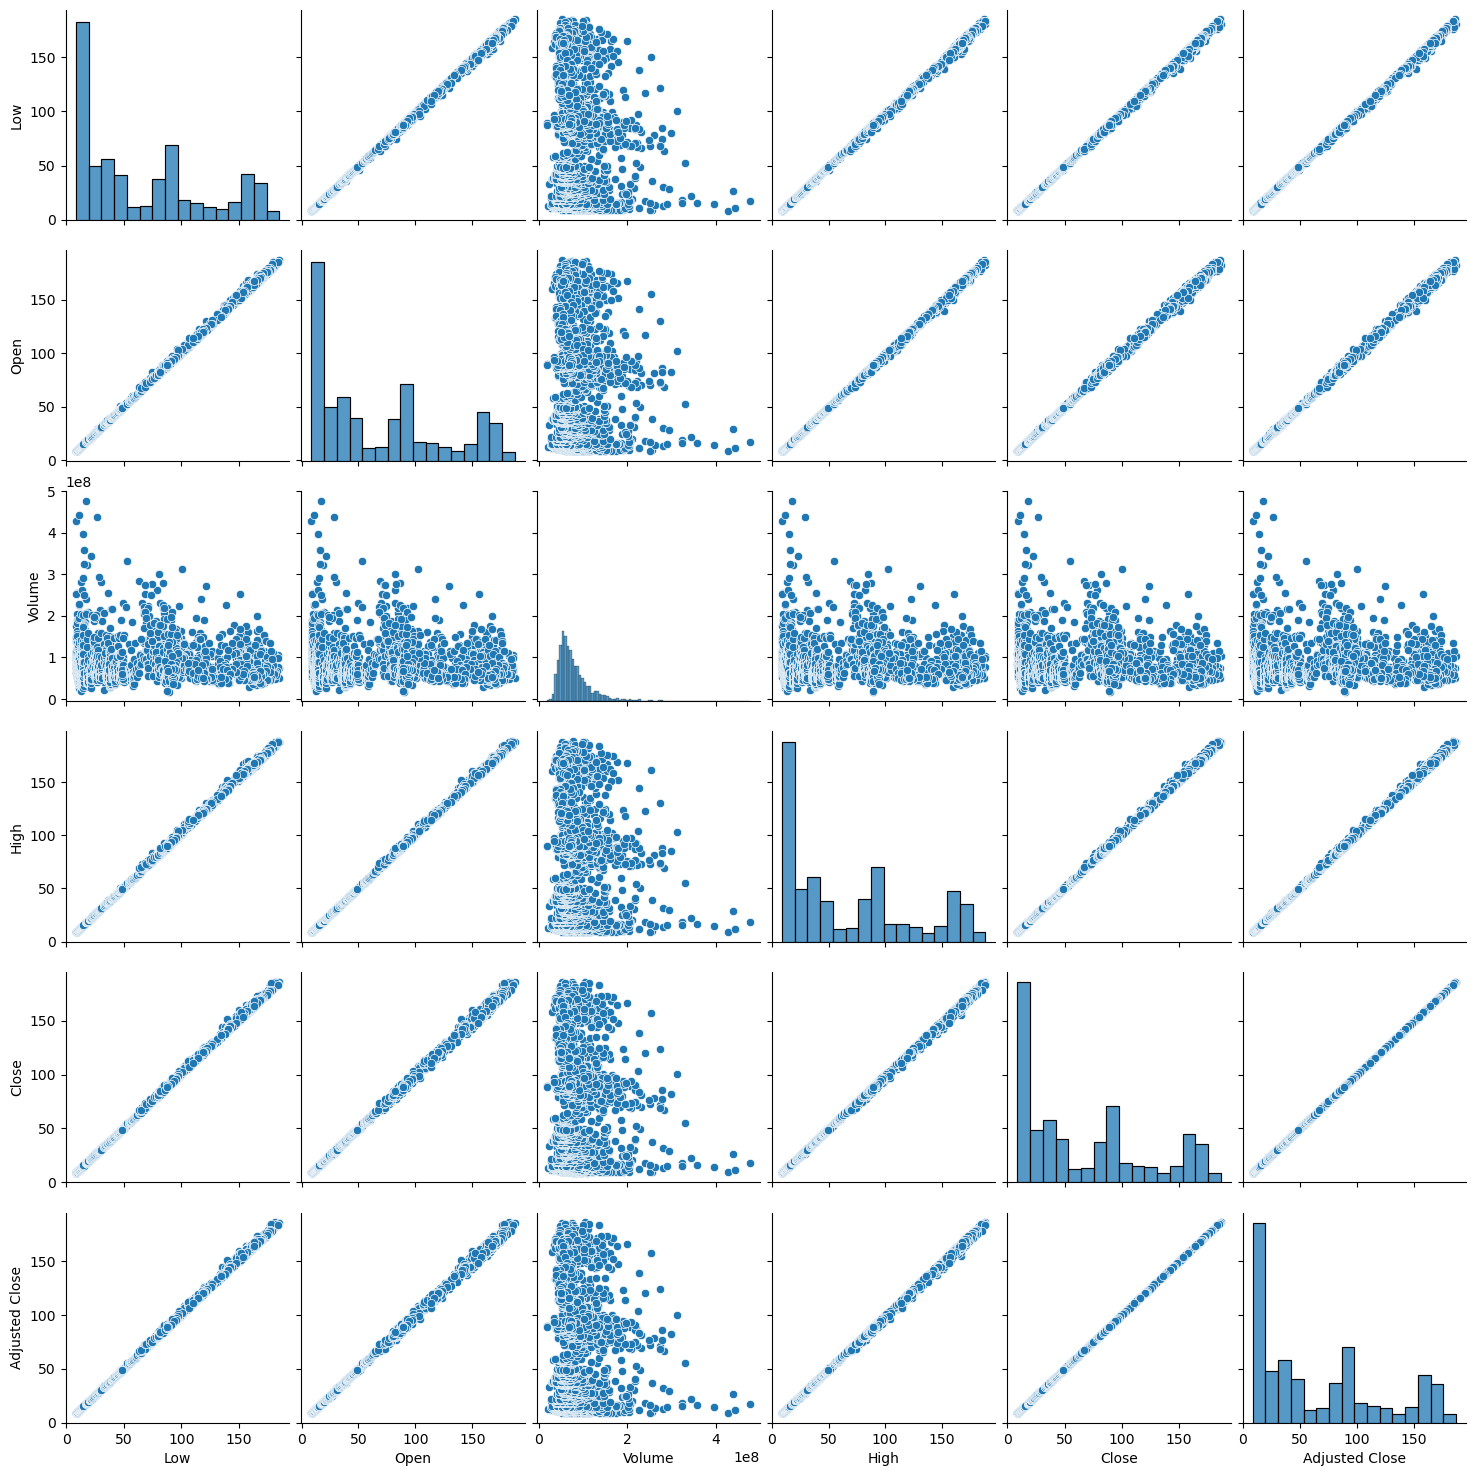

In [45]:
amzn['Date'] = pd.to_datetime(amzn['Date'])
sns.pairplot(amzn)
plt.show()

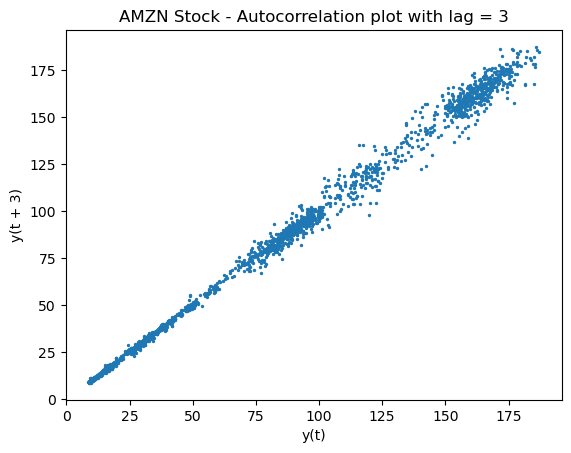

In [53]:
plt.figure()
lag_plot(amzn['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

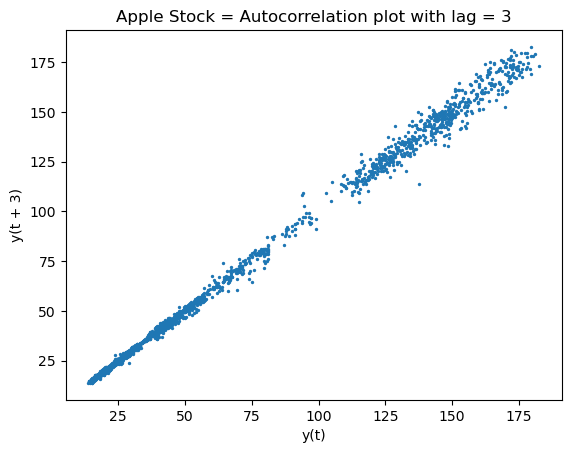

In [55]:
plt.figure()
lag_plot(aapl['Open'], lag=3, s = 2)
plt.title('Apple Stock = Autocorrelation plot with lag = 3')
plt.show()

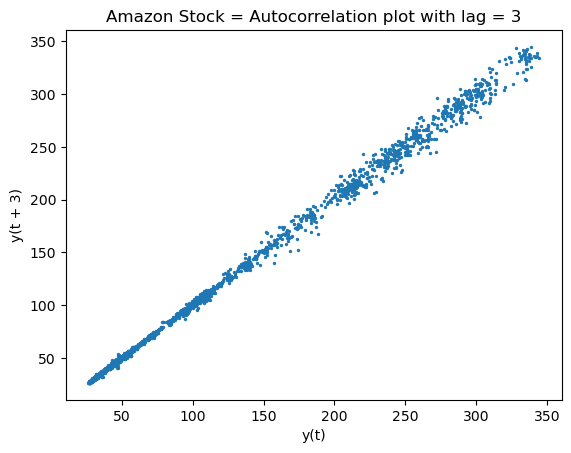

In [54]:
plt.figure()
lag_plot(msft['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

##### Seeing these lag plots show that there  is a linear pattern and ARIMA will be a suited 